In [1]:
from agent.agent import Agent
from envs import TradingEnv
from functions import *
import torch
import yaml, os
import csv
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def write_to_csv(writer, environment, epsilon, t):
    """
    Writes three rows to csv: 
        first is profit, value held, max_staked, and epsilon; 
        second is buy indices; 
        third is sell indices
    """
    writer.writerow([environment.net_profit(t), environment.value_held(t), environment.max_spent,epsilon])
    writer.writerow(environment.buys)
    writer.writerow(environment.sells)

In [3]:
profits_list = [] # Will hold list of all profits as we go through training
with open(os.path.join(os.getcwd(), 'config.yml'), 'r') as stream:
    config = yaml.load(stream)

test_name = "^HSI_2018"
stock_name, window_size, episode_count = config['stock_name'], config['window_size'], config["num_epochs"]

num_tech_indicators = config['num_tech_indicators']
agent = Agent(window_size + num_tech_indicators, config)
data = getStockDataVec(stock_name)
test_data = getStockDataVec(test_name)
env = TradingEnv(data, window_size)
env_test = TradingEnv(test_data, window_size)
l = len(data) - 1
l1 = len(test_data) - 1

test_portfolio = []  # test_portfolio[i] will hold a tuple of the list of all buys and sells
out_filename = "test_progressiond.csv"
out_writer = open(out_filename,'a')
writer = csv.writer(out_writer, delimiter=',')
train_out_writer = open("train_progressiond.csv",'a')
train_writer = csv.writer(train_out_writer,delimiter=',')
episode_count = 1
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = env.get_state(0)

    env.reset_holdings()

    for t in range(l):
        action = agent.act(state)

        # sit
        next_state = env.get_state(t + 1)
        reward = 0

        if action == 1: # buy
            #remembers the price bought at t, and the time bought
            env.buy(t)
            # print("Buy: " + formatPrice(data[t]))

        elif action == 2: # sell
            reward, profit = env.sell(t)
            # print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(profit))

        done = True if t == l - 1 else False
        # Push all values to memory
        agent.memory.push(state, action, next_state, reward)
        state = next_state
        total_profit = env.net_profit(t)
        max_staked = env.max_spent
        

        if done:
            # First we test the agent
            state1 = env_test.get_state(0)

            for t1 in range(l1):
                action = agent.act(state1)
                if action == 1:
                    env_test.buy(t1)
                elif action == 2:
                    env_test.sell(t1)
                state1 = env_test.get_state(t1+1)

            # then we record our progress in the csv's
            write_to_csv(writer, env_test, agent.epsilon, t1)
            write_to_csv(train_writer, env, agent.epsilon, t)
            test_percent_return = env_test.net_profit(t1) / env_test.max_spent * 100
            
            
            percent_return = total_profit / max_staked * 100
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("Max staked: " + formatPrice(max_staked))
            print("Percent return: " + "{0:.2f}%".format(percent_return))
            print("Test return: " + "{0:.2f}%".format(test_percent_return))
            print("--------------------------------")
            profits_list.append((total_profit, percent_return))
#             print(profits_list)
        agent.optimize()

    if e % config['save_freq'] == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())
        torch.save(agent.policy_net, config['policy_model'])
        torch.save(agent.target_net, config['target_model'])
        
out_writer.close()
train_out_writer.close()

<ipython-input-3-4a53a2164647>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(stream)


Episode 0/1


/Users/Eric/Desktop/QuantRL/final-product/functions.py:47: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1*x))


--------------------------------
Total Profit: $2085282.25
Max staked: $1906214.65
Percent return: 109.39%
Test return: 71.29%
--------------------------------
Episode 1/1
--------------------------------
Total Profit: $508503.06
Max staked: $362403.04
Percent return: 140.31%
Test return: 63.34%
--------------------------------


In [4]:
test_name = "^HSI_2018"
test_data = np.array(getStockDataVec(test_name))
l1 = len(test_data) - 1

train_name = "^HSI"
train_data = np.array(getStockDataVec(train_name))
l = len(train_data - 1)
x_data = range(l1 + 1)

In [5]:
df = pd.read_csv('test_progression5.csv', header=None, sep='\n', nrows = 1500)
df = df[0].str.split(',', expand=True).astype(np.float)
df.shape

(1013, 490)

In [6]:
print(df[:3])

          0     1              2          3     4     5     6     7     8    \
0  1477.45508   0.0  363410.316405   0.997048   NaN   NaN   NaN   NaN   NaN   
1     8.00000  11.0      14.000000  16.000000  17.0  25.0  27.0  31.0  36.0   
2     9.00000  18.0      20.000000  23.000000  26.0  28.0  29.0  33.0  39.0   

    9    ...  480  481  482  483  484  485  486  487  488  489  
0   NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  37.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  40.0  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[3 rows x 490 columns]


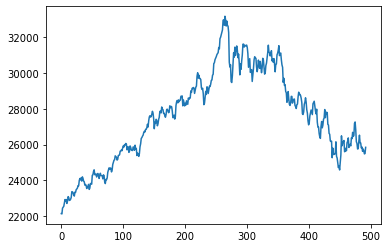

In [7]:
plt.plot(test_data)

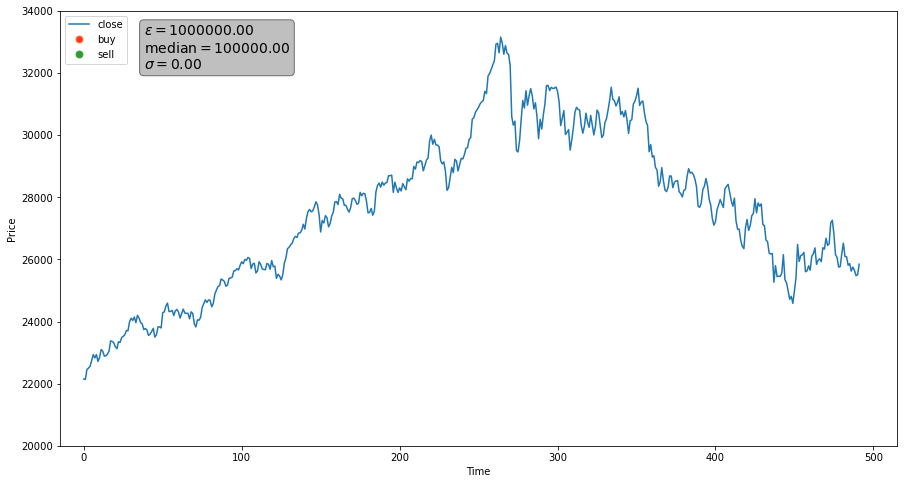

In [8]:
fig, ax = plt.subplots(figsize=(15,8))

ax.set_xlim(( -15, 515))
ax.set_ylim((20000, 34000))
# ax.set_xlim(( -200, 7600))
# ax.set_ylim((0, 34000))



close_plot, = ax.plot(x_data, test_data[:])
buys_plot, = ax.plot([], [], '.',marker='o',markersize=7, markerfacecolor='r', alpha=.8)
sells_plot, = ax.plot([],[], '.',marker='o',markersize=7, markerfacecolor='g', alpha=.8)

ax.legend(['close', 'buy', 'sell'], loc='upper left')
ax.set_xlabel("Time")
ax.set_ylabel("Price")

textstr = '\n'.join((
    r'$\epsilon=%.2f$' % (1000000, ),
    r'$\mathrm{median}=%.2f$' % (100000, ),
    r'$\sigma=%.2f$' % (0, )))

props = dict(boxstyle='round', facecolor='gray', alpha=0.5)

# place a text box in upper left in axes coords
text = ax.text(0.1, 0.97, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)


def init():
    buys_plot.set_data([], [])
    sells_plot.set_data([],[])
    return (close_plot, buys_plot,sells_plot, text)

In [9]:
skip = 5
truncate = 1
rows_per = 3
def animate(i):
    i *= skip  # to reduce frames, we skip some
    ax.set_title("Episode " + str(i) + " / " + str(int(df.shape[0] // rows_per // truncate)))
    i *= rows_per
    buys = df[i+1:i+2].to_numpy().flatten()
    sells = df[i+2:i+3].to_numpy().flatten()
    buys = buys[np.isfinite(buys)].astype(int)
    sells = sells[np.isfinite(sells)].astype(int)
    sells_plot.set_data(sells,test_data[sells])
    buys_plot.set_data(buys,test_data[buys])

    
    return (close_plot, buys_plot,sells_plot, text)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(df.shape[0]/ rows_per / truncate / skip), interval=50, 
                               blit=True)


In [10]:
HTML(anim.to_jshtml())

In [11]:
freq = 3
rows_per_data = 3
profits = []
def shorten_file(old_fname, new_fname):
    # first is profit, value held, max_staked, and epsilon; 
    profit = []
    value_held = []
    max_staked = []
    with open(old_fname, 'r') as inp, open(new_fname, 'w') as out:
        writer = csv.writer(out)
        i = 0
        since = 0
        for row in csv.reader(inp):
            if since > 0 or i % (freq * rows_per_data) == 0:
#                 since += 1
#                 print(row[0], row[1], row[2])
                profit.append(float(row[0]))
                value_held.append(float(row[1]))
                max_staked.append(float(row[2]))
#                 writer.writerow(row)
                if since == rows_per_data:
                    since = 0
            i += 1
            if i % 500 == 0:
                print(i)
        return np.array(profit),np.array(value_held),np.array(max_staked)


In [12]:
profit_train, value_held_train, max_staked_train = shorten_file("train_progression5.csv",
                                                                "train_progression_short.csv")
profit_test, value_held_test, max_staked_test = shorten_file("test_progression5.csv",
                                                                "test_progression_short.csv")

500
1000
500
1000


39.089524420883734
1.6215722057491295


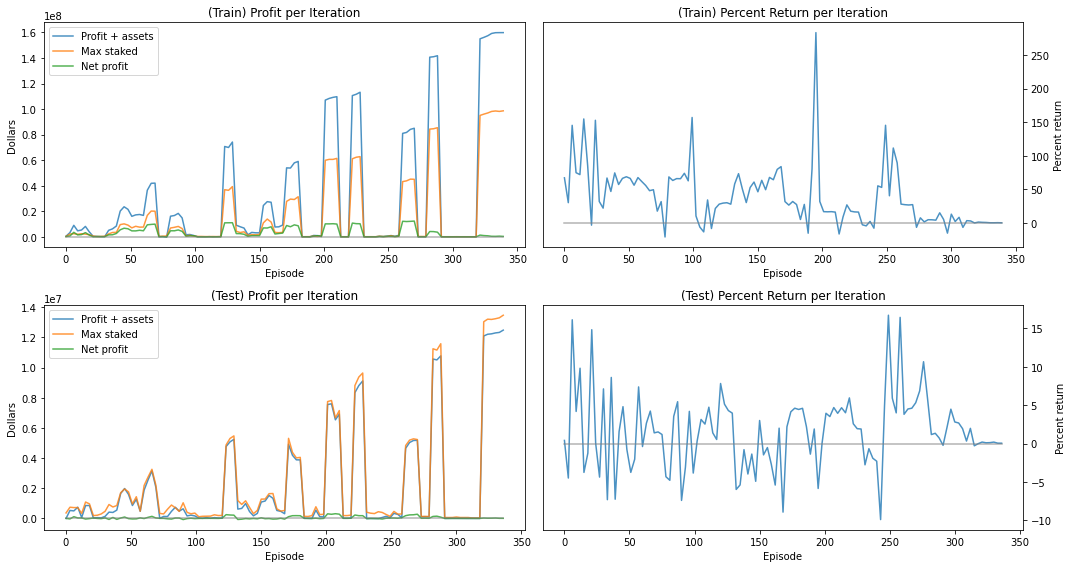

In [13]:
def visualize_prog(s, ax1, ax2):
    if s == "train":
        cap = "(Train)"
        profit = profit_train
        value_held = value_held_train
        max_staked = max_staked_train
    else:
        cap = "(Test)"
        profit = profit_test
        value_held = value_held_test
        max_staked = max_staked_test



    
    x_data = np.arange(len(profit)) * 3
    ax1.plot(x_data, profit, alpha=.8)
    ax1.plot(x_data, max_staked, alpha=.8)
    ax1.plot(x_data, profit - value_held, alpha=.8)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Dollars")
    
    ax1.set_title(cap + " Profit per Iteration")
    ax1.plot(x_data, np.zeros(len(x_data)), color="gray", alpha=.6)
    ax1.legend(["Profit + assets","Max staked", "Net profit"])

    
    percent_return = (profit - value_held)/max_staked * 100
    percent_return2 = profit / max_staked * 100
    ax2.plot(x_data, percent_return, alpha=.8)
    print(percent_return.mean())
#     ax2.plot(x_data, percent_return2, alpha=.8)
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Percent return")
    ax2.set_title(cap + " Percent Return per Iteration")
    ax2.plot(x_data, np.zeros(len(x_data)), color="gray", alpha=.6)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
#     ax2.legend(["Return no assets","Return with assets"])
    
    
fig, axs = plt.subplots(2,2, figsize=(15,8))
# print(axs)
visualize_prog("train", axs[0][0], axs[0][1])
visualize_prog("test", axs[1][0], axs[1][1])
# visualize_rate("train",axs[0][1])
# visualize_rate("test",axs[1][0])
# visualize_prog("test")
fig.tight_layout()
